# Preminary operations

Let us start by importing the relevant packages

In [62]:
import gcp
import gcp.bigquery as bq
import gcp.storage as storage
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.colors as colors
import numpy as np
import seaborn as sns

## Let us explore the dataset

In [63]:
%%sql 
SELECT * FROM [google.com:ddm-connectors-demo:aw_dataset.__TABLES__];

project_id,dataset_id,table_id,creation_time,last_modified_time,row_count,size_bytes,type
google.com:ddm-connectors-demo,aw_dataset,ACCOUNT_PERFORMANCE_DEVICE,1462865492924,1462865646222,344872,213766803,1
google.com:ddm-connectors-demo,aw_dataset,ACCOUNT_PERFORMANCE_HOUR_OF_DAY,1462866241157,1462868328687,7585976,4293195830,1
google.com:ddm-connectors-demo,aw_dataset,CAMPAIGN_PERFORMANCE_DEVICE,1462882853869,1462884926720,12818403,11156943261,1
google.com:ddm-connectors-demo,aw_dataset,CAMPAIGN_PERFORMANCE_GA,1462886351515,1462888587490,12818403,11092304675,1
google.com:ddm-connectors-demo,aw_dataset,CAMPAIGN_PERFORMANCE_HOUR_OF_DAY,1462890199029,1462910444516,149020493,120843835228,1
google.com:ddm-connectors-demo,aw_dataset,KEYWORDS_GROUPS,1464543183153,1464543183648,0,0,1
google.com:ddm-connectors-demo,aw_dataset,KEYWORDS_PERFORMANCE_ANALYTICS,1462965362235,1463059120058,295426051,435427263267,1
google.com:ddm-connectors-demo,aw_dataset,KEYWORDS_PERFORMANCE_DEVICE,1463050362280,1463408383328,447387461,631380449113,1


## Lest us explore the table KEYWORDS_PERFORMANCE_ANALYTICS

In [64]:
%bigquery schema --table google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS

## Let us see how the data look like

In [6]:
%bigquery sample --table google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS --count 5

AccountCurrencyCode,AccountDescriptiveName,AccountTimeZoneId,ActiveViewCpm,ActiveViewCtr,ActiveViewImpressions,ActiveViewMeasurability,ActiveViewMeasurableCost,ActiveViewMeasurableImpressions,ActiveViewViewability,AdGroupId,AdGroupName,AdGroupStatus,AdNetworkType1,AdNetworkType2,AllConversionRate,AllConversions,AllConversionValue,ApprovalStatus,AverageCost,AverageCpc,AverageCpe,AverageCpm,AverageCpv,AveragePageviews,AveragePosition,AverageTimeOnSite,BaseAdGroupId,BaseCampaignId,BiddingStrategyId,BiddingStrategyName,BiddingStrategySource,BiddingStrategyType,BidType,BounceRate,CampaignId,CampaignName,CampaignStatus,ClickAssistedConversionsOverLastClickConversions,ClickAssistedConversionValue,ClickConversionRate,Clicks,ConversionRate,Conversions,ConversionValue,ConvertedClicks,Cost,CostPerAllConversion,CostPerConversion,CostPerConvertedClick,CpcBid,CpcBidSource,CpmBid,CreativeQualityScore,Criteria,CriteriaDestinationUrl,CrossDeviceConversions,Ctr,CustomerDescriptiveName,Date,DayOfWeek,EngagementRate,Engagements,EnhancedCpcEnabled,EstimatedAddClicksAtFirstPositionCpc,EstimatedAddCostAtFirstPositionCpc,ExternalCustomerId,FinalAppUrls,FinalMobileUrls,FinalUrls,FirstPageCpc,FirstPositionCpc,GmailForwards,GmailSaves,GmailSecondaryClicks,Id,ImpressionAssistedConversions,ImpressionAssistedConversionsOverLastClickConversions,ImpressionAssistedConversionValue,Impressions,InteractionRate,Interactions,IsNegative,KeywordMatchType,LabelIds,Labels,Month,MonthOfYear,PercentNewVisitors,PostClickQualityScore,PrimaryCompanyName,QualityScore,Quarter,SearchExactMatchImpressionShare,SearchImpressionShare,SearchPredictedCtr,SearchRankLostImpressionShare,Status,SystemServingStatus,TopOfPageCpc,TrackingUrlTemplate,UrlCustomParameters,ValuePerAllConversion,ValuePerConversion,ValuePerConvertedClick,VideoQuartile100Rate,VideoQuartile25Rate,VideoQuartile50Rate,VideoQuartile75Rate,VideoViewRate,VideoViews,ViewThroughConversions,Week,Year
EUR,Bravofly FR,(GMT+01:00) Paris,20000000,11.11%,9,100.00%,180000,11,81.82%,4742873125,Bravofly Misspellings,enabled,Display Network,Display Network,0.00%,0.0,0.0,--,180000,180000,0,16363636,0,1.0,1.0,0,4742873125,98913565,0,--,campaign,cpc,--,100.00%,98913565,Brand Content,enabled,0.0,0.0,0.00%,1,0.00%,0.0,0.0,0,180000,0,0,0,--,--,--,Not applicable,Content,--,0.0,9.09%,Bravofly FR,2015-09-30,Wednesday,0.00%,0,False,--,--,9348411392,--,--,--,0,0,0,0,0,3000000,0,0.0,0.0,11,9.09%,1,False,Broad,--,--,2015-09-01,September,100.00%,Not applicable,"Red Universal de Marketing y Bookings On Line, S.A.",0,2015-07-01,--,--,Not applicable,--,enabled,eligible,0,--,--,0.0,0.0,0.0,0.00%,0.00%,0.00%,0.00%,0.00%,0,0,2015-09-28,2015
EUR,Bravofly Russia Voli,(GMT+01:00) Rome,0,0.00%,0,0.00%,0,0,0.00%,3639849698,Bravoavia,enabled,Search Network,Google search,0.00%,0.0,0.0,--,140000,140000,0,17500000,0,7.0,4.8,139,3639849698,108030218,0,--,campaign,cpc,--,0.00%,108030218,Brand_RU_Broad,enabled,0.0,0.0,0.00%,1,0.00%,0.0,0.0,0,140000,0,0,0,--,--,--,Not applicable,бравоавиа билеты,--,0.0,12.50%,Bravofly Russia Voli,2015-03-22,Sunday,0.00%,0,False,--,--,9837210897,--,--,--,0,0,0,0,0,33239627618,0,0.0,0.0,8,12.50%,1,False,Broad,--,--,2015-03-01,March,0.00%,Not applicable,"Red Universal de Marketing y Bookings On Line, S.A.",0,2015-01-01,--,57.14%,Not applicable,42.86%,removed,--,0,--,--,0.0,0.0,0.0,0.00%,0.00%,0.00%,0.00%,0.00%,0,0,2015-03-16,2015
EUR,Bravofly Russia Voli,(GMT+01:00) Rome,0,0.00%,0,0.00%,0,0,0.00%,3639850178,Bravofly,enabled,Search Network,Search partners,0.00%,0.0,0.0,--,0,0,0,0,0,0.0,1.0,0,3639850178,108030218,0,--,campaign,cpc,--,0.00%,108030218,Brand_RU_Broad,enabled,0.0,0.0,0.00%,0,0.00%,0.0,0.0,0,0,0,0,0,--,--,--,Not applicable,bravofly,--,0.0,0.00%,Bravofly Russia Voli,2015-03-19,Thursday,0.00%,0,False,--,--,9837210897,--,--,--,0,0,0,0,0,3117710189,0,0.0,0.0,1,0.00%,0,False,Phrase,--,--,2015-03-01,March,0.00%,Not applicable,"Red Universal de Marketing y Bookings On Line, S.A.",0,2015-01-01,--,100.00%,Not applicable,0.00%,remo

# Let us start checking the monthly performance on Volagratis in Italy

In [65]:
%sql --module monthly_keywords_performance
SELECT
  AccountDescriptiveName,
  CampaignName,
  AdGroupName,
  Criteria,
  KeywordMatchType,
  COUNT(Month) as MonthsWithImpressions,
  AVG(Impressions) as Impressions,
  AVG(ImpressionAssistedConversions) as ImpressionAssistedConversions,
  AVG(Clicks) as Clicks,
  AVG(ClickAssistedConversions) as ClickAssistedConversions,  
  AVG(CTR) as CTR,
  AVG(CostEUR/Clicks) as CPC,
  AVG(QualityScore) as QualityScore, 
  AVG(CostEUR) as CostEUR,
  AVG(AllConversions) as AllConversions,
  AVG(Conversions) as Conversions,    
  AVG(CostPerAllConversion) as CostPerAllConversion,
  AVG(CostPerConversion) as CostPerConversion,  
  #Analytics Metrics
  AVG(BounceRate) as BounceRate,
  AVG(AveragePosition) as AveragePosition,
  AVG(AveragePageviews) as AveragePageviews,
  AVG(AverageTimeOnSite) as AverageTimeOnSite,
  AVG(PercentNewVisitors) as PercentNewVisitors,
FROM
(
SELECT
  Month,
  AccountDescriptiveName,
  CampaignName,
  AdGroupName,
  Criteria,
  KeywordMatchType,
  SUM(Impressions) as Impressions,
  SUM(ImpressionAssistedConversions) as ImpressionAssistedConversions,
  SUM(Clicks) as Clicks,
  SUM(Clicks)/SUM(Impressions) as CTR,
  SUM(IF(ClickAssistedConversionsOverLastClickConversions = 0, 0,
  CASE
    WHEN Conversions > 0 OR AllConversions > 0 THEN IF(AllConversions>Conversions,AllConversions,Conversions)*ClickAssistedConversionsOverLastClickConversions
    WHEN ImpressionAssistedConversions > 0 THEN ImpressionAssistedConversions*ClickAssistedConversionsOverLastClickConversions
    ELSE 1.0
  END
  )) as ClickAssistedConversions,
  
  AVG(QualityScore) as QualityScore,
  
  SUM(IF(AccountCurrencyCode = 'GBP', Cost*1.37, Cost*1.0))/1000000 as CostEUR,
  SUM(AllConversions) as AllConversions,
  SUM(Conversions) as Conversions,  
  
  SUM(IF(AccountCurrencyCode = 'GBP', Cost*1.37, Cost*1.0))/1000000/SUM(AllConversions) as CostPerAllConversion,
  SUM(IF(AccountCurrencyCode = 'GBP', Cost*1.37, Cost*1.0))/1000000/SUM(Conversions) as CostPerConversion,
  
  #Analytics Metrics
  SUM(FLOAT(RTRIM(BounceRate,'%'))/100.0 * Clicks)/SUM(Clicks) as BounceRate,
  SUM(AveragePosition * Impressions)/SUM(Impressions) as AveragePosition,
  SUM(AveragePageviews * Clicks)/SUM(Clicks) as AveragePageviews,
  SUM(AverageTimeOnSite * Clicks)/SUM(Clicks) as AverageTimeOnSite,
  SUM(FLOAT(RTRIM(PercentNewVisitors,'%'))/100.0 * Clicks)/SUM(Clicks) as PercentNewVisitors,

FROM
  [google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS]
WHERE TRUE
AND NOT IsNegative
AND AdNetworkType2 = 'Google search'
AND Impressions > 0 
AND Year = 2015
AND AccountDescriptiveName IN ('Account Primario Volagratis','Volagratis Tratte Italia','Volagratis')
GROUP BY 1,2,3,4,5,6)
GROUP BY 1,2,3,4,5

In [ ]:
df = bq.Query(monthly_keywords_performance).to_dataframe()

First of all let us identify the Brand Keywords assuming that 
- they have at least 10 impressions a month
- their CTR is higher the "normal"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06040a0f50>]], dtype=object)

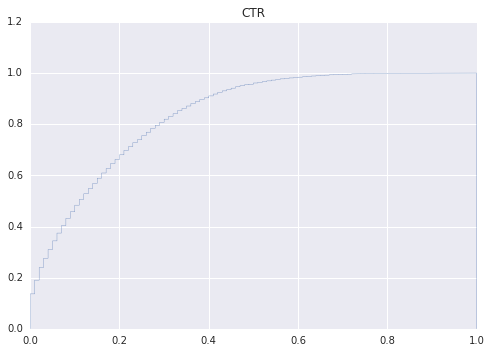

In [9]:
df[df['Impressions']>10].hist('CTR',bins=np.arange(101)/100.0,
                              normed=True,cumulative=1,histtype='step')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f060406af90>]], dtype=object)

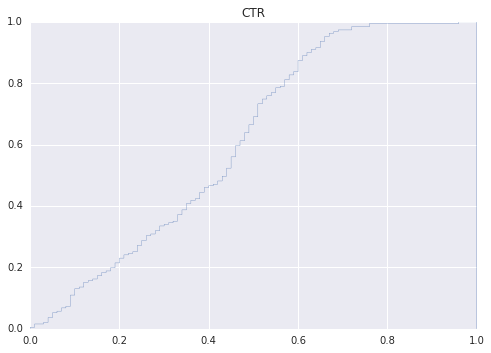

In [10]:
df[(df['AdGroupName'] == 'Brand')&(df['Impressions']>10)].hist('CTR',bins=np.arange(101)/100.0,
                                                              cumulative=1,normed=1,
                                                               histtype='step')

In [11]:
df[(df['AdGroupName'] == 'Brand')&
   (df['CTR']<0.4)&
   (df['Impressions']>10)].sort_values(by='CostEUR',ascending=False)[['AccountDescriptiveName',
                                                                                        'CampaignName',
                                                                                        'AdGroupName',
                                                                                        'Criteria',
                                                                                        'KeywordMatchType',
                                                                                        'CTR',
                                                                                        'Impressions',
                                                                                        'CostEUR']]

,AccountDescriptiveName,CampaignName,AdGroupName,Criteria,KeywordMatchType,CTR,Impressions,CostEUR
53524,Account Primario Volagratis,Volagratis Brand 2008,Brand,+vola +gratis,Broad,0.297325,13794.500000,1243.685000
38085,Account Primario Volagratis,Volagratis Brand 2008,Brand,volagratis,Broad,0.224826,10817.500000,660.385000
120003,Account Primario Volagratis,Volagratis Brand 2008,Brand,+volagratis,Broad,0.296902,8457.750000,590.672500
160179,Account Primario Volagratis,Volagratis Brand 2008,Brand,volaregratis,Broad,0.167032,4562.000000,260.050000
78747,Account Primario Volagratis,Volagratis Brand 2008,Brand,volarequasigratis,Broad,0.131890,5914.000000,259.500000
130754,Account Primario Volagratis,Volagratis Brand 2008,Brand,viaggiogratis,Broad,0.090241,4499.000000,255.890000
79136,Account Primario Volagratis,Volagratis Brand 2008,Brand,+volagratis. +com,Broad,0.246051,1877.750000,103.552500
150977,Account Primario Volagratis,Volagratis Brand 2008,Brand,+voli +gratis,Broad,0.244225,596.000000,48.150000
114839,Account Primario Volagratis,Volagratis Brand 2008,Brand,+volagratis +prenotazione,Broad,0.126770,733.000000,44.845000
101220,Account Primario Volagratis,Volagratis Brand 2008,Brand,volare gratis,Broad,0.093334,2942.000000,44.595000


In [12]:
df[(df['Impressions']>10) & (df['CTR']>0.4)].sort_values(by='CostEUR',ascending=False)[['AccountDescriptiveName',
                                                                                        'CampaignName',
                                                                                        'AdGroupName',
                                                                                        'Criteria',
                                                                                        'KeywordMatchType',
                                                                                        'CTR',
                                                                                        'Impressions',
                                                                                        'CostEUR']]

,AccountDescriptiveName,CampaignName,AdGroupName,Criteria,KeywordMatchType,CTR,Impressions,CostEUR
42259,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volagratis,Exact,0.512981,752063.500000,24342.210000
38545,Account Primario Volagratis,Volagratis Brand 2008 - Exact Experiment Cross...,Brand,volagratis,Exact,0.495577,96324.000000,1883.100000
30125,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,vola+gratis,Exact,0.515747,33721.500000,1326.177500
132073,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Missp,voli gratis,Exact,0.528934,7947.500000,940.237500
1270,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volare+gratis,Exact,0.529607,13439.750000,763.860000
133096,Account Primario Volagratis,Volagratis Brand 2008,Voli Brand,+volagratis +volo,Broad,0.457367,4743.250000,604.257500
4278,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volagratis offerte speciali,Exact,0.652958,2975.000000,542.875000
100282,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volagratis offerte,Exact,0.651954,5517.750000,515.712500
134606,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Missp,vologratis,Exact,0.589290,6880.500000,401.912500
7816,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volaregratis,Exact,0.483906,13941.750000,318.510000


In [13]:
df['KeywordType'] = df.apply(lambda x: 'Gold' if 
                             (x['Impressions']>10 and x['CTR']>0.4) 
                             else 'Standard', axis=1)


Let us start assessing the performance of the keywords from the AllConversions

In [14]:
df.groupby(by=(df['AllConversions'] > 0))[['AllConversions','ClickAssistedConversions',
                                           'ImpressionAssistedConversions','CostEUR',
                                           'Impressions','Clicks',
                                           'Criteria']].aggregate({'AllConversions':sum,
                                                                   'ClickAssistedConversions':sum,
                                                                   'ImpressionAssistedConversions':sum,
                                                                   'CostEUR':sum,
                                                                   'Impressions':sum,
                                                                   'Clicks':sum,
                                                                   'Criteria':'count'})

,ClickAssistedConversions,CostEUR,ImpressionAssistedConversions,AllConversions,Criteria,Impressions,Clicks
AllConversions,,,,,,,
False,1.750000,128969.6125,4323.416667,0.00,159796,2.707570e+06,3.272166e+05
True,14630.233333,357421.8450,19706.750000,27315.25,8023,6.563169e+06,1.202290e+06


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f060c6af350>]], dtype=object)

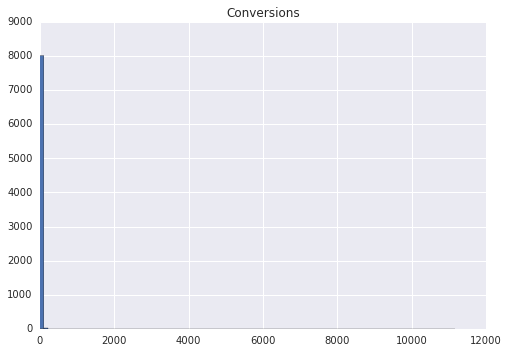

In [15]:
df[df['AllConversions'] > 0].hist('Conversions',bins=100)

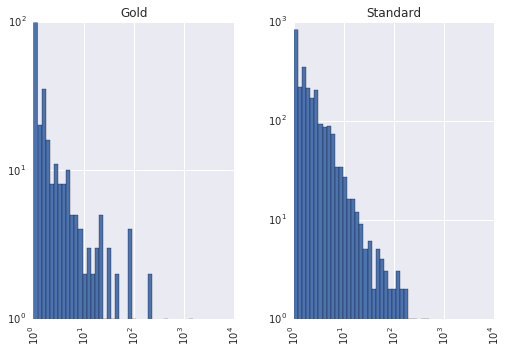

In [16]:
axes = df[df['AllConversions'] > 0].hist('AllConversions',bins=np.logspace(0,4),log=True,by='KeywordType')
axes[0].set_xscale('log')
axes[1].set_xscale('log')

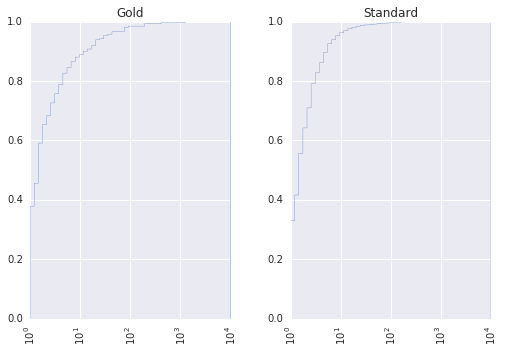

In [17]:
axes = df[df['AllConversions'] > 0].hist('AllConversions',bins=np.logspace(0,4),by='KeywordType',
              cumulative=1,normed=True,histtype='step')
axes[0].set_xscale('log')
axes[1].set_xscale('log')

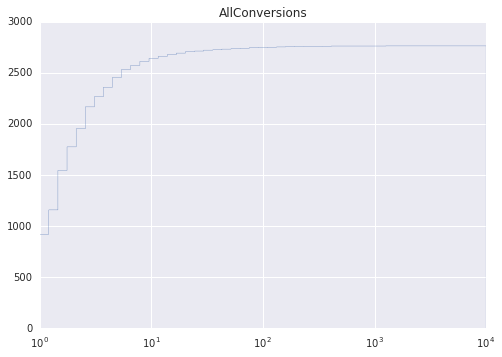

In [18]:
df[df['AllConversions'] > 0].hist('AllConversions',bins=np.logspace(0,4),
              cumulative=1,histtype='step')
plt.gca().set_xscale('log')

In [19]:
def setGroup(x):
  if x['AllConversions'] > 0:
    return 'Converter'
  else:
    return 'Other'
  
def setSubGroup(x):
  if x['AllConversions'] > 99:
    return 'Converter - High'
  elif x['AllConversions'] > 9:
    return 'Converter - Mid'
  elif x['AllConversions'] > 2:
    return 'Converter - Low'
  elif x['AllConversions'] > 0:
    return 'Converter - Occasional'
  else:
    return 'Other'
  
df['Group'] = df.apply(setGroup,axis=1)
df['SubGroup'] = df.apply(setSubGroup,axis=1)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


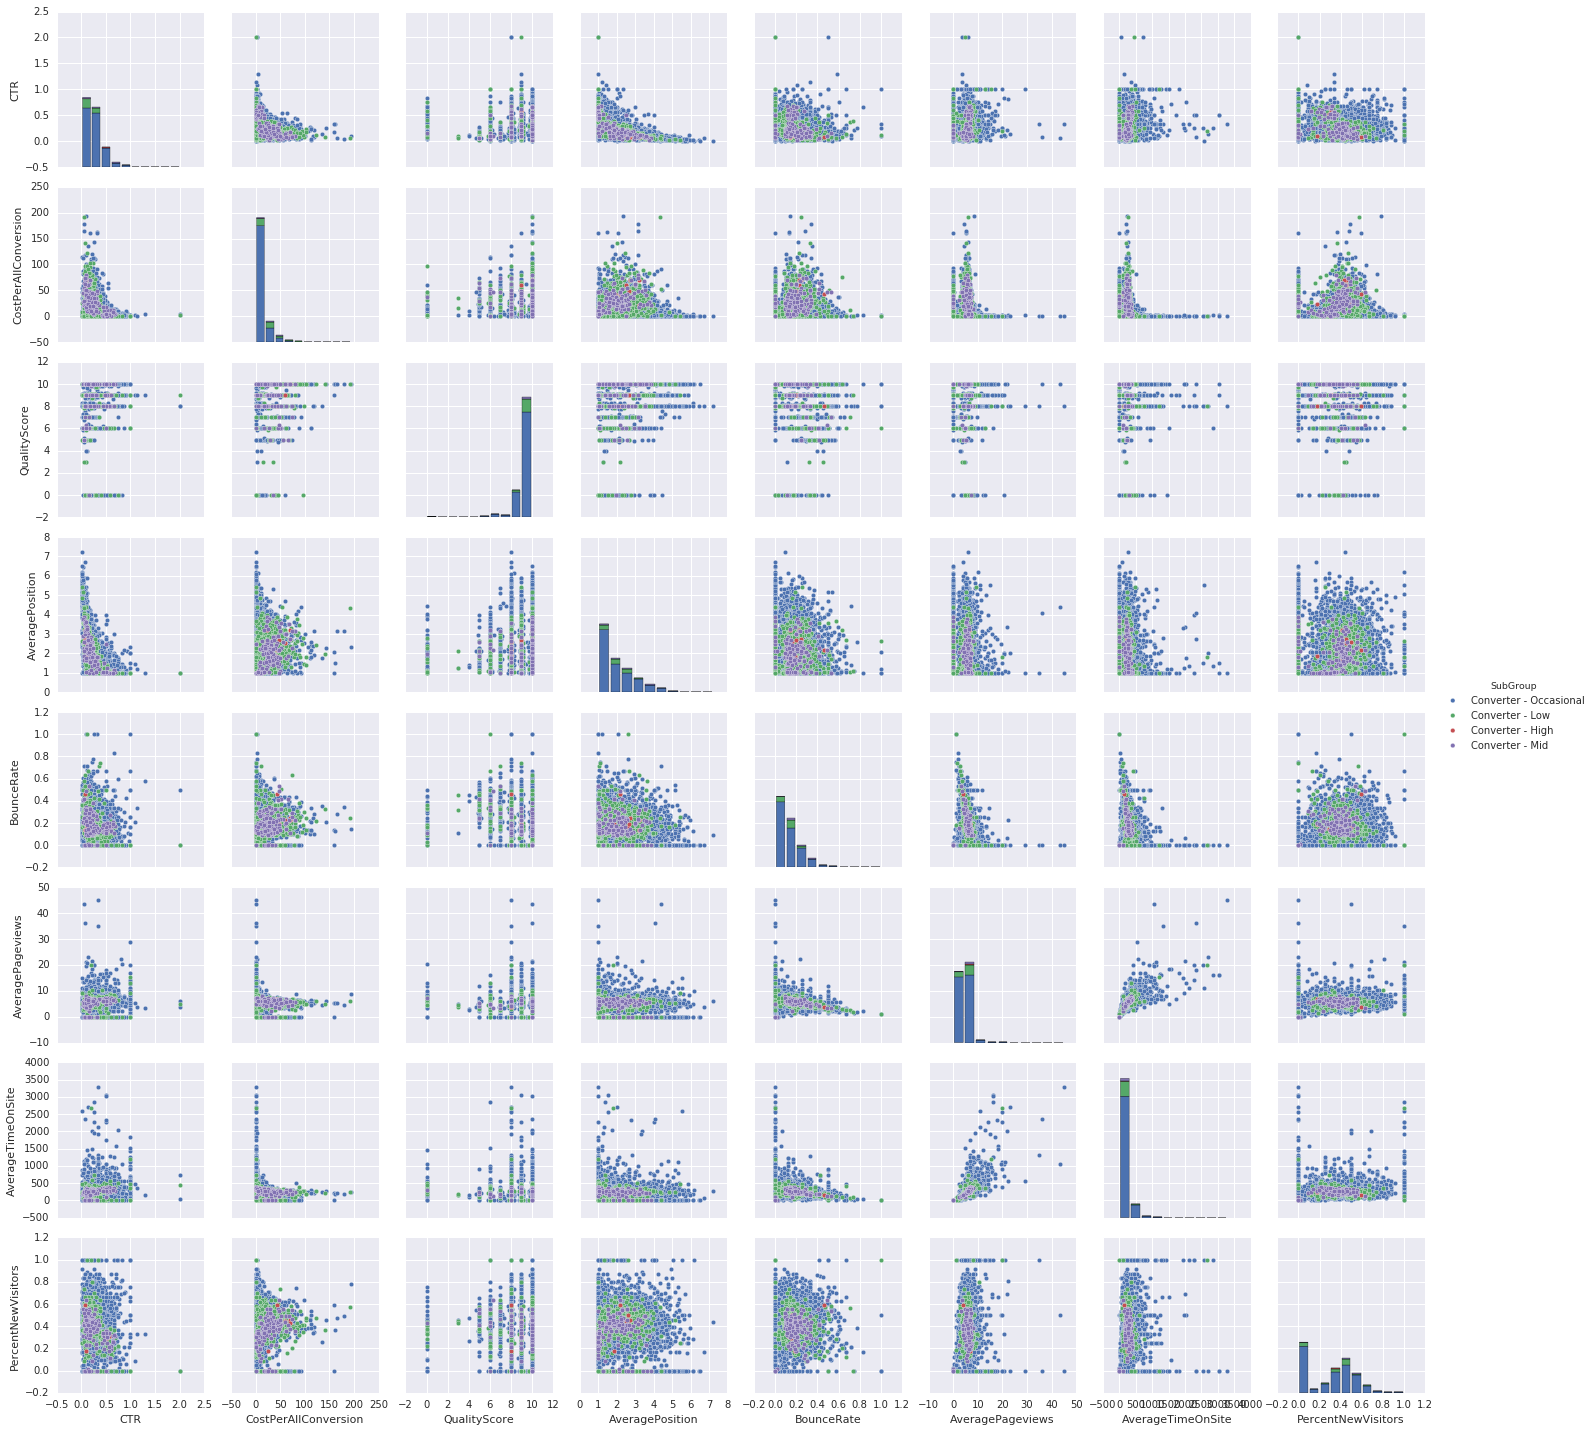

In [20]:
g = sns.pairplot(data=df[df['Group'] == 'Converter'][[u'SubGroup','CTR',
                                                  'CostPerAllConversion',
                            u'QualityScore',u'AveragePosition',                          
                            u'BounceRate', u'AveragePageviews',
                            u'AverageTimeOnSite',u'PercentNewVisitors']],hue=u'SubGroup')

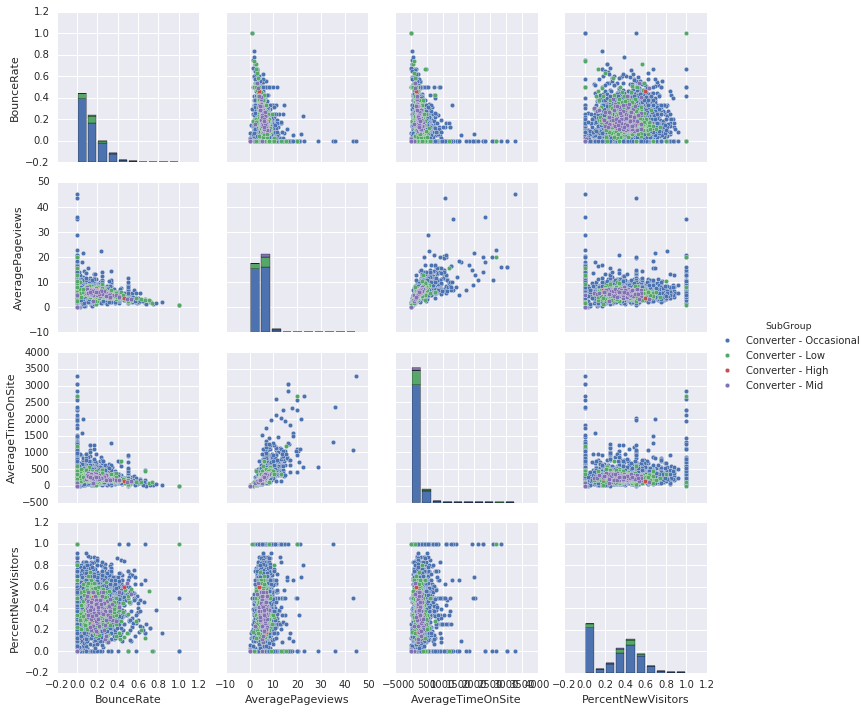

In [21]:
g = sns.pairplot(data=df[df['Group'] == 'Converter'][[u'SubGroup',                         
                            u'BounceRate', u'AveragePageviews',
                            u'AverageTimeOnSite',u'PercentNewVisitors']],hue=u'SubGroup')

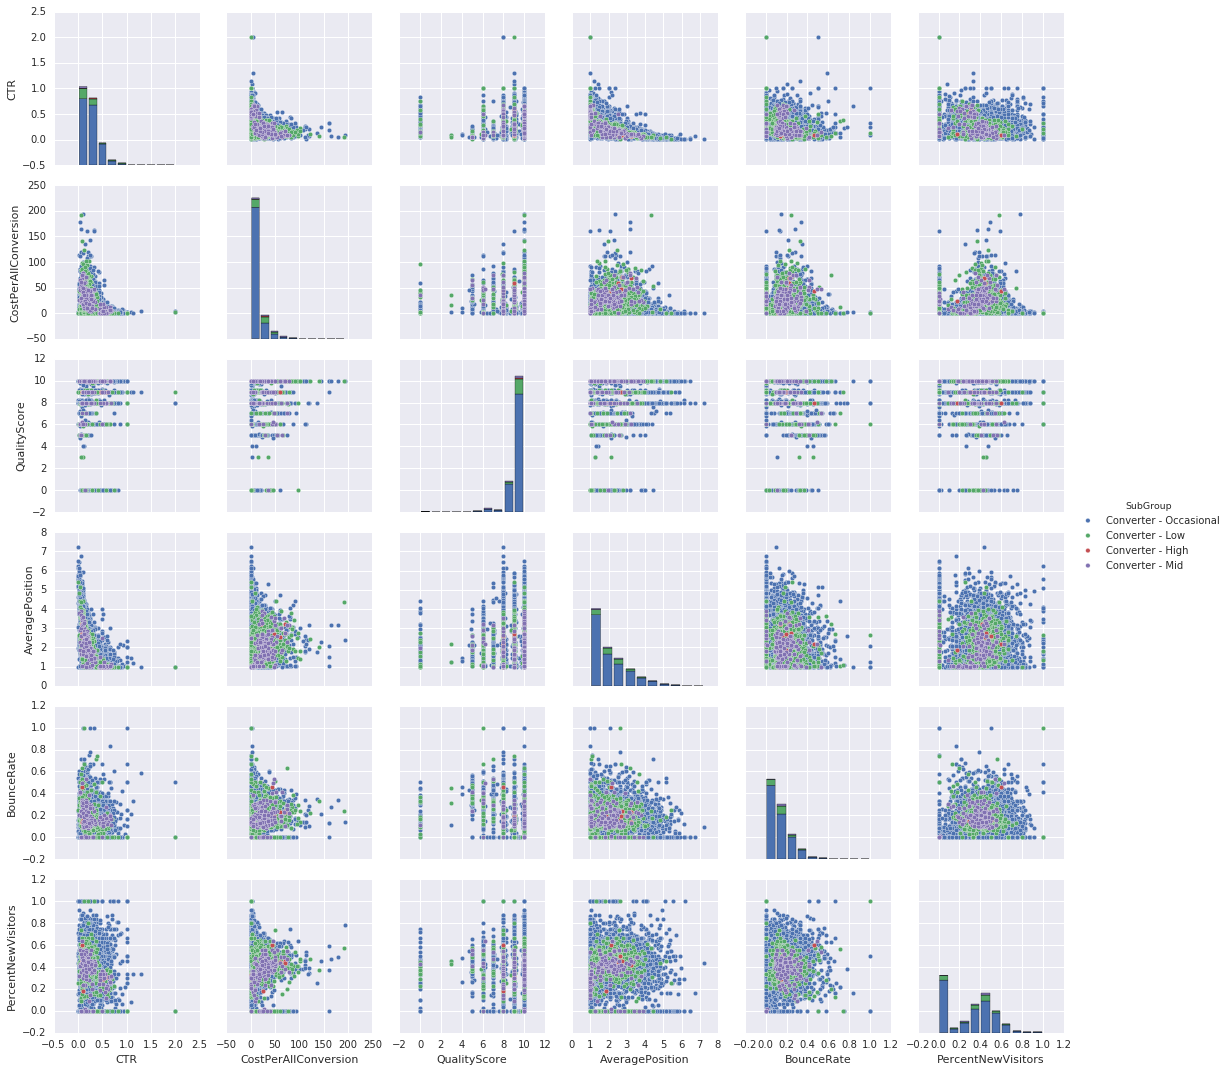

In [22]:
g = sns.pairplot(data=df[df['Group'] == 'Converter'][[u'SubGroup','CTR',
                                                  'CostPerAllConversion',
                            u'QualityScore',u'AveragePosition',                          
                            u'BounceRate',u'PercentNewVisitors']],hue=u'SubGroup')

Can we move away from LastClick?

In [23]:
df.groupby(by='SubGroup')[['AllConversions','ClickAssistedConversions',
                        'ImpressionAssistedConversions',
                        'CostEUR','Impressions','Clicks',
                        'Criteria']].aggregate({'AllConversions':sum,
                                                'ClickAssistedConversions':sum,
                                                'ImpressionAssistedConversions':sum,
                                                'CostEUR':sum,
                                                'Impressions':sum,
                                                'Clicks':sum,
                                                'Criteria':'count'})

,ClickAssistedConversions,CostEUR,ImpressionAssistedConversions,AllConversions,Criteria,Impressions,Clicks
SubGroup,,,,,,,
Converter - High,10768.850000,123228.950000,7389.750000,16266.083333,17,2.391588e+06,627049.833333
Converter - Low,869.750000,68204.411667,3515.750000,3206.000000,826,1.112613e+06,160315.500000
Converter - Mid,2163.416667,85393.607500,4462.833333,3490.916667,145,1.399455e+06,187159.000000
Converter - Occasional,828.216667,80594.875833,4338.416667,4352.250000,7035,1.659514e+06,227766.166667
Other,1.750000,128969.612500,4323.416667,0.000000,159796,2.707570e+06,327216.583333


In [24]:
df[df['Group'] == 'Other'].groupby(by=(df[df['Group'] == 'Other']['ClickAssistedConversions'] +
                                       df[df['Group'] == 'Other']['ImpressionAssistedConversions']>0))[
  ['ClickAssistedConversions','ImpressionAssistedConversions','CostEUR',
   'Impressions','Clicks','Criteria']].aggregate({'ClickAssistedConversions':sum,
                                                  'ImpressionAssistedConversions':sum,
                                                  'CostEUR':sum,
                                                  'Impressions':sum,
                                                  'Clicks':sum,
                                                  'Criteria':'count'})

,ClickAssistedConversions,CostEUR,ImpressionAssistedConversions,Criteria,Impressions,Clicks
False,0.00,112287.461667,0.000000,154426,1.886971e+06,267007.333333
True,1.75,16682.150833,4323.416667,5370,8.205995e+05,60209.250000


In [25]:
def setGroup(x):
  if x['AllConversions'] > 0:
    return 'Converter'
  elif x['Clicks'] > 0:
    return 'Click'
  else:
    return 'Impressions'
  
def setSubGroup(x):
  if x['AllConversions'] > 99:
    return 'Converter - High'
  elif x['AllConversions'] > 9:
    return 'Converter - Mid'
  elif x['AllConversions'] > 2:
    return 'Converter - Low'
  elif x['AllConversions'] > 0:
    return 'Converter - Occasional'
  elif x['Clicks'] > 0:
    return 'Click'
  else:
    return 'Impressions'
  
df['Group'] = df.apply(setGroup,axis=1)
df['SubGroup'] = df.apply(setSubGroup,axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05f4e13590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f05f6b4f150>]], dtype=object)

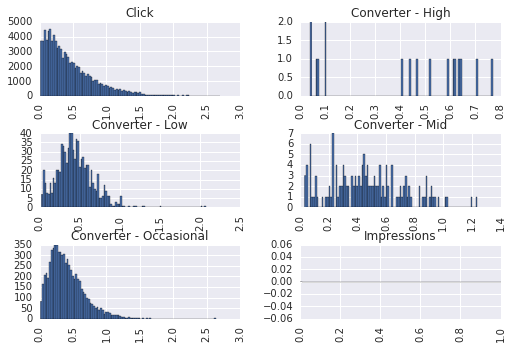

In [26]:
df.hist('CPC',by='SubGroup',bins=100)

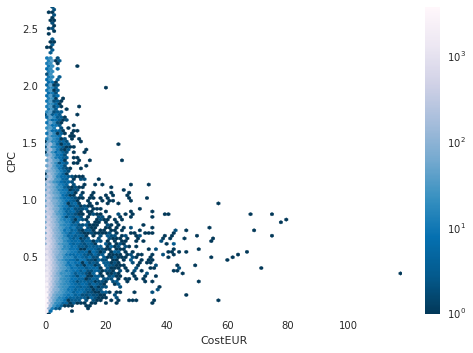

In [27]:
with sns.axes_style({ 'axes.facecolor': 'white','axes.grid': False}):
  fig,ax = plt.subplots()
  data=df[df['Group'] == 'Click'].plot(x='CostEUR',y='CPC', 
                                     kind='hexbin',ax=ax,
                                     norm=colors.LogNorm(),
                                     cmap='PuBu_r',
                                     mincnt=1)

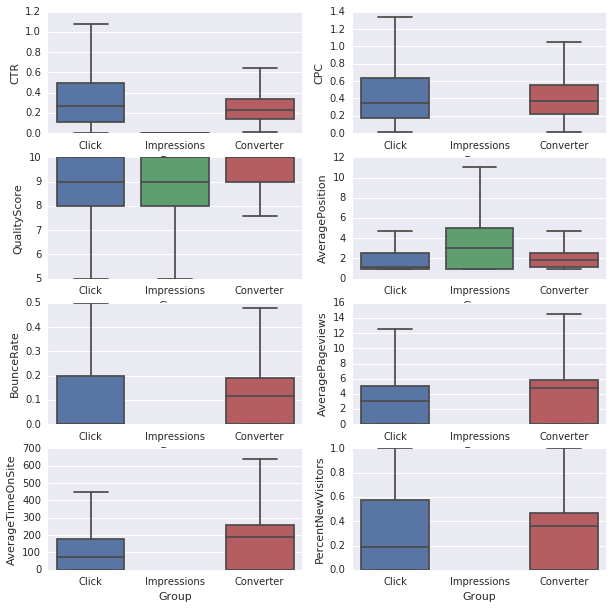

In [28]:
metrics = ['CTR','CPC',u'QualityScore',u'AveragePosition',                          
           u'BounceRate',u'AveragePageviews',u'AverageTimeOnSite',
           u'PercentNewVisitors']

fig, ax_arr = plt.subplots( 4, 2,figsize=(10,10))

for i in range(len(metrics)):  
  sns.boxplot(data=df,y=metrics[i],x='Group',ax=ax_arr[i/2][(i%4)%2],showfliers=False)



In [29]:
threshold = df[df['Group'] == 'Converter'][metrics].median()

In [30]:
def setGroup(x):
  if x['AllConversions'] > 0:
    return 'Converter'
  elif x['Clicks'] > 0:
    return 'Click'
  else:
    return 'Impressions'
  
def setSubGroup(x,threshold=threshold):
  if x['AllConversions'] > 99:
    return 'Converter - High'
  elif x['AllConversions'] > 9:
    return 'Converter - Mid'
  elif x['AllConversions'] > 2:
    return 'Converter - Low'
  elif x['AllConversions'] > 0:    
    return 'Converter - Occasional'
  elif x['Clicks'] > 0:
    score = 0
    if x['CTR'] > threshold['CTR']:
      score+=1
      
    if x['CPC'] < threshold['CPC']:
      score+=1

    if x['QualityScore'] >= threshold['QualityScore']:
      score+=1
      
    if x['BounceRate'] < threshold['BounceRate']:
      score+=1    
    
    if x['AveragePageviews'] > threshold['AveragePageviews']:
      score+=1
      
    if x['AverageTimeOnSite'] > threshold['AverageTimeOnSite']:
      score+=1

    if x['PercentNewVisitors'] > threshold['PercentNewVisitors']:
      score+=1
      
    if x['AveragePosition'] < threshold['AveragePosition']:
      score+=1 
    
    return 'Click - {0:02d}'.format(score/3)  
  else:
    score = 0
    if x['QualityScore'] >= threshold['QualityScore']:
      score+=1
    
    if x['AveragePosition'] < threshold['AveragePosition']:
      score+=1

    return 'Impressions - {0:02d}'.format(score)  
  
df['Group'] = df.apply(setGroup,axis=1)
df['SubGroup'] = df.apply(setSubGroup,axis=1)

In [31]:
df.groupby(by='SubGroup')[['AllConversions','ClickAssistedConversions',
                        'ImpressionAssistedConversions',
                        'CostEUR','Impressions','Clicks',
                        'Criteria']].aggregate({'AllConversions':sum,
                                                'ClickAssistedConversions':sum,
                                                'ImpressionAssistedConversions':sum,
                                                'CostEUR':sum,
                                                'Impressions':sum,
                                                'Clicks':sum,
                                                'Criteria':'count'})

,ClickAssistedConversions,CostEUR,ImpressionAssistedConversions,AllConversions,Criteria,Impressions,Clicks
SubGroup,,,,,,,
Click - 00,0.750000,19840.980000,1037.416667,0.000000,17400,7.180846e+05,53863.666667
Click - 01,1.000000,91778.872500,2544.416667,0.000000,66318,1.557360e+06,232507.750000
Click - 02,0.000000,17349.760000,330.833333,0.000000,11868,1.643257e+05,40845.166667
Converter - High,10768.850000,123228.950000,7389.750000,16266.083333,17,2.391588e+06,627049.833333
Converter - Low,869.750000,68204.411667,3515.750000,3206.000000,826,1.112613e+06,160315.500000
Converter - Mid,2163.416667,85393.607500,4462.833333,3490.916667,145,1.399455e+06,187159.000000
Converter - Occasional,828.216667,80594.875833,4338.416667,4352.250000,7035,1.659514e+06,227766.166667
Impressions - 00,0.000000,0.000000,190.166667,0.000000,21866,1.108471e+05,0.000000
Impressions - 01,0.000000,0.000000,203.583333,0.000000,34027,1.396895e+05,0.000000


In [60]:
demo_context = gcp.Context.default()
ddm_context = gcp.Context(project_id='google.com:ddm-connectors-demo',
                          credentials=gcp.Context.default().credentials)

bigquery_dataset_name = 'aw_dataset'
bigquery_table_name = 'KEYWORDS_GROUPS'

# Define BigQuery dataset and table
dataset = bq.DataSet(name=bigquery_dataset_name,context=ddm_context)
table = bq.Table(bigquery_dataset_name + '.' + bigquery_table_name,context=ddm_context)

# Create BigQuery dataset
if not dataset.exists():
    dataset.create()

# Create or overwrite the existing table if it exists
table_schema = bq.Schema.from_dataframe(df[[u'AccountDescriptiveName', 
                                            u'CampaignName',u'AdGroupName', 
                                            u'Criteria', u'KeywordMatchType',
                                            u'Group',u'SubGroup']])
table.create(schema = table_schema, overwrite = True)

# Write the DataFrame to a BigQuery table
table.insert_data(df[[u'AccountDescriptiveName', u'CampaignName',u'AdGroupName', u'Criteria', u'KeywordMatchType',u'Group',u'SubGroup']])

AccountDescriptiveName,CampaignName,AdGroupName,Criteria,KeywordMatchType,Group,SubGroup
Volagratis Tratte Italia,voli Tratte Italia - Europa 3,Firenze - Budapest,Firenze-Budapest,Phrase,Click,Click - 01
Account Primario Volagratis,Voli Tratte Italia - Europa 2,Venezia - Colonia,voli Venezia Colonia,Phrase,Converter,Converter - Occasional
Account Primario Volagratis,Voli Generiche 2008 - Exact,gruppi,voli per gruppi,Exact,Click,Click - 01
Volagratis,Voli Tratte Mondo - Italia 7,Sofia - Palermo,Sofia Palermo,Phrase,Impressions,Impressions - 00
Account Primario Volagratis,Voli Tratte Italia - Italia,Bari - Milano,aerei da Bari a Linate,Phrase,Click,Click - 01
Account Primario Volagratis,Voli Tratte Italia - Italia,Venezia - Reggio Calabria,Venezia-Reggio Calabria,Phrase,Click,Click - 00
Account Primario Volagratis,Voli Destinazioni Europa 2008,Ibiza Voli,+voli +aerei +per +ibiza,Broad,Impressions,Impressions - 00
Account Primario Volagratis,Voli Tratte Italia - Europa 1 - Exact,Milano - Monaco,Malpensa Monaco Lowcost,Exact,Impressions,Impressions - 01
Account Primario Volagratis,Voli Destinazioni Europa 2008,Milos Voli,+voli +low +cost +milos,Broad,Impressions,Impressions - 00
Volagratis Tratte Italia,voli Tratte Italia - Europa 3 Exact,Roma - Formentera,Roma-Formentera,Exact,Click,Click - 00


In [61]:
%bigquery sample --table google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_GROUPS --count 5

AccountDescriptiveName,CampaignName,AdGroupName,Criteria,KeywordMatchType,Group,SubGroup
Volagratis Tratte Italia,voli Tratte Italia - Europa 3,Firenze - Budapest,Firenze-Budapest,Phrase,Click,Click - 01
Account Primario Volagratis,Voli Destinazioni Europa 2008,Ibiza Voli,+voli +aerei +per +ibiza,Broad,Impressions,Impressions - 00
Account Primario Volagratis,Voli Tratte Italia - Europa 1 - Exact,Milano - Monaco,Malpensa Monaco Lowcost,Exact,Impressions,Impressions - 01
Volagratis Tratte Italia,voli Tratte Italia - Europa 3 Exact,Roma - Formentera,Roma-Formentera,Exact,Click,Click - 00
Volagratis Tratte Italia,Tratte EN Phrase,Milan - Geneva,Milan to Geneva flights,Phrase,Impressions,Impressions - 01


In [ ]:
%sql -module query_group
